In [1]:
import pickle
X_acl,X_ppg,y_hr,y_participant = pickle.load(open('../data/tabular_data.p','rb'))

In [2]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

for k in range(X_ppg.shape[0]):
    X_ppg[k] = MinMaxScaler().fit_transform(X_ppg[k])

import numpy as np
X_ppg = X_ppg[:,np.arange(0,512,2),:]

X_acl = np.concatenate([X_ppg,X_acl],axis=-1)[:,:,:]

y = X_ppg[:,:,0].reshape(-1,256,1)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,Attention,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input
from keras.models import Model, Sequential

In [6]:
logo = LeaveOneGroupOut()
logo = LeavePGroupsOut(n_groups=5)
for train_index, test_index in logo.split(X_acl, y, y_participant.reshape(-1)):
    train_x, test_x = X_acl[train_index], X_acl[test_index]
    train_y, test_y = y[train_index], y[test_index]
    train_participant, test_participant = y_participant[train_index], y_participant[test_index]
    train_hr, test_hr = y_hr[train_index], y_hr[test_index]
    break
train_x.shape,train_y.shape

((29067, 256, 4), (29067, 256, 1))

In [7]:
train_x, val_x, train_y, val_y, train_hr, val_hr = train_test_split(train_x,train_y,train_hr,test_size = 0.2,random_state=42)

(train_x.shape, train_y.shape, train_hr.shape), (val_x.shape, val_y.shape),(test_x.shape,test_y.shape,test_hr.shape)

(((23253, 256, 4), (23253, 256, 1), (23253,)),
 ((5814, 256, 4), (5814, 256, 1)),
 ((14296, 256, 4), (14296, 256, 1), (14296,)))

In [103]:
from keras_self_attention import SeqSelfAttention
from keras import backend as K
from keras.layers import Concatenate, Flatten,LeakyReLU, Activation, RepeatVector, Permute, Multiply, Lambda, Dense, merge# Define a regular layer instead of writing a custom layer
# This layer should have just one neuron - like before
# The weights and bias shapes are automatically calculated 
# by the Framework, based on the input
# This layer is defined at step 3.5 directly

def custom_loss(y_true,y_pred):
    y_pred_attention = y_pred[:,:,1]
    y_pred = y_pred[:,:,0]
    y_true = y_true[:,:,0]
    loss = K.mean(K.abs(y_true-y_pred)*y_pred_attention)
    return loss


def get_model(input_shape=(256,4),act='relu',loss="mae",opt='adam',n_classes=1):
#     model =  Sequential()
#     model.add(GaussianNoise(1))
#     model.add(Conv1D(100,20,activation='linear',kernel_initializer='normal',padding='same'))
#     model.add(Conv1D(10,10,activation='relu',kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    
    model2 =  Sequential()
    model2.add(Conv1D(100,20,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(5))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(100,20,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(5))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(50,20,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(2))
    model2.add(BatchNormalization())
    model2.add(Flatten())
    model2.add(Dense(20,activation='relu'))
    model2.add(Reshape((10,2)))
    model2.add(Conv1D(100,2,input_shape=input_shape,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(256,2,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model2.add(Permute([2,1]))
#     model2.add(TimeDistributed(Dense(1,activation='relu')))
    
#     model2.add(Flatten())
#     model2.add(Dense(20,activation='relu'))
#     model2.add(Dense(128,activation='relu'))
#     model2.add(Dense(256,activation='relu'))
#     model2.add(Reshape((256,1)))
    model2.add(Conv1D(10,20,activation='relu',kernel_initializer='normal',padding='same'))
    model2.add(Conv1D(10,20,activation='relu',kernel_initializer='normal',padding='same'))
#     model2.add(BatchNormalization())
    model2.add(TimeDistributed(Dense(1,activation='sigmoid')))
    
    x = Input(shape=input_shape)
    x_encoded = Conv1D(4,20,activation='sigmoid',kernel_initializer='normal',padding='same')(x)
#     e=Dense(1, activation='tanh')(x_encoded)# Now do all the softmax business taking the above o/p
#     e=Dense(1, activation='sigmoid')(e)
    e = Conv1D(1,20,activation='sigmoid',kernel_initializer='normal',padding='same')(x_encoded)
    
    e=Flatten()(e)
    a=Activation('softmax')(e)
    a = a*256
    temp=RepeatVector(4)(a)
    temp=Permute([2, 1])(temp)# multiply weight with lstm layer o/p
    output = merge.Multiply()([x_encoded, temp])
    output = model2(output)
    a1 = RepeatVector(1)(a)
    a1 = Permute([2, 1])(a1)
    output = Concatenate()([output,a1])
    model1 = Model(inputs=x,outputs=output)
    model1.compile(loss=custom_loss,optimizer=opt)
    return model1

    
    
#     model.add(Bidirectional(LSTM(100,return_sequences=True,activation='tanh',kernel_initializer='normal')))
#     model.add(TimeDistributed(Dense(1,activation='')))
    

In [104]:
model = get_model()
model.summary()
model_json = model.to_json()
from keras.models import load_model
filepath = '../model_files/convolutional_autoencoder_weights.hdf5'
model_filepath = '../model_files/convolutional_autoencoder.json'
with open(model_filepath, "w") as json_file:
    json_file.write(model_json)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d_128 (Conv1D)             (None, 256, 4)       324         input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 256, 1)       81          conv1d_128[0][0]                 
__________________________________________________________________________________________________
flatten_29 (Flatten)            (None, 256)          0           conv1d_129[0][0]                 
___________________________________________________________________________________________

In [105]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=500, batch_size=500,
          callbacks=callbacks_list,shuffle=True)

Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 0.1635
Epoch 00001: val_loss improved from inf to 0.17912, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 1s 26ms/step - loss: 0.1635 - val_loss: 0.1791
Epoch 2/500
46/47 [============================>.] - ETA: 0s - loss: 0.1568
Epoch 00002: val_loss did not improve from 0.17912
47/47 [==============================] - 1s 21ms/step - loss: 0.1567 - val_loss: 0.1812
Epoch 3/500
46/47 [============================>.] - ETA: 0s - loss: 0.1541
Epoch 00003: val_loss did not improve from 0.17912
47/47 [==============================] - 1s 21ms/step - loss: 0.1541 - val_loss: 0.1834
Epoch 4/500
46/47 [============================>.] - ETA: 0s - loss: 0.1461
Epoch 00004: val_loss did not improve from 0.17912
47/47 [==============================] - 1s 21ms/step - loss: 0.1460 - val_loss: 0.1873
Epoch 5/500
46/47 [============================>.] - ETA: 0s - loss: 

Epoch 33/500
46/47 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00033: val_loss did not improve from 0.06950
47/47 [==============================] - 1s 21ms/step - loss: 0.0737 - val_loss: 0.0712
Epoch 34/500
46/47 [============================>.] - ETA: 0s - loss: 0.0730
Epoch 00034: val_loss improved from 0.06950 to 0.06804, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 1s 22ms/step - loss: 0.0730 - val_loss: 0.0680
Epoch 35/500
46/47 [============================>.] - ETA: 0s - loss: 0.0726
Epoch 00035: val_loss did not improve from 0.06804
47/47 [==============================] - 1s 21ms/step - loss: 0.0726 - val_loss: 0.0712
Epoch 36/500
46/47 [============================>.] - ETA: 0s - loss: 0.0724
Epoch 00036: val_loss did not improve from 0.06804
47/47 [==============================] - 1s 21ms/step - loss: 0.0724 - val_loss: 0.0686
Epoch 37/500
46/47 [============================>.] - ETA: 0s

46/47 [============================>.] - ETA: 0s - loss: 0.0692
Epoch 00068: val_loss did not improve from 0.06466
47/47 [==============================] - 1s 21ms/step - loss: 0.0692 - val_loss: 0.0665
Epoch 69/500
46/47 [============================>.] - ETA: 0s - loss: 0.0691
Epoch 00069: val_loss did not improve from 0.06466
47/47 [==============================] - 1s 21ms/step - loss: 0.0691 - val_loss: 0.0652
Epoch 70/500
46/47 [============================>.] - ETA: 0s - loss: 0.0687
Epoch 00070: val_loss did not improve from 0.06466
47/47 [==============================] - 1s 21ms/step - loss: 0.0687 - val_loss: 0.0652
Epoch 71/500
46/47 [============================>.] - ETA: 0s - loss: 0.0687
Epoch 00071: val_loss did not improve from 0.06466
47/47 [==============================] - 1s 21ms/step - loss: 0.0687 - val_loss: 0.0652
Epoch 72/500
46/47 [============================>.] - ETA: 0s - loss: 0.0690
Epoch 00072: val_loss did not improve from 0.06466
47/47 [==============

Epoch 105/500
46/47 [============================>.] - ETA: 0s - loss: 0.0670
Epoch 00105: val_loss did not improve from 0.06346
47/47 [==============================] - 1s 22ms/step - loss: 0.0671 - val_loss: 0.0640
Epoch 106/500
46/47 [============================>.] - ETA: 0s - loss: 0.0673
Epoch 00106: val_loss improved from 0.06346 to 0.06306, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 1s 22ms/step - loss: 0.0673 - val_loss: 0.0631
Epoch 107/500
46/47 [============================>.] - ETA: 0s - loss: 0.0669
Epoch 00107: val_loss did not improve from 0.06306
47/47 [==============================] - 1s 21ms/step - loss: 0.0669 - val_loss: 0.0656
Epoch 108/500
46/47 [============================>.] - ETA: 0s - loss: 0.0673
Epoch 00108: val_loss did not improve from 0.06306
47/47 [==============================] - 1s 21ms/step - loss: 0.0673 - val_loss: 0.0632
Epoch 109/500
46/47 [============================>.] - ET

46/47 [============================>.] - ETA: 0s - loss: 0.0660
Epoch 00141: val_loss did not improve from 0.06238
47/47 [==============================] - 1s 22ms/step - loss: 0.0660 - val_loss: 0.0631
Epoch 142/500
46/47 [============================>.] - ETA: 0s - loss: 0.0662
Epoch 00142: val_loss did not improve from 0.06238
47/47 [==============================] - 1s 22ms/step - loss: 0.0663 - val_loss: 0.0628
Epoch 143/500
46/47 [============================>.] - ETA: 0s - loss: 0.0658
Epoch 00143: val_loss improved from 0.06238 to 0.06229, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 1s 22ms/step - loss: 0.0658 - val_loss: 0.0623
Epoch 144/500
46/47 [============================>.] - ETA: 0s - loss: 0.0661
Epoch 00144: val_loss did not improve from 0.06229
47/47 [==============================] - 1s 21ms/step - loss: 0.0661 - val_loss: 0.0626
Epoch 145/500
46/47 [============================>.] - ETA: 0s - loss: 

Epoch 177/500
46/47 [============================>.] - ETA: 0s - loss: 0.0653
Epoch 00177: val_loss did not improve from 0.06151
47/47 [==============================] - 1s 22ms/step - loss: 0.0653 - val_loss: 0.0651
Epoch 178/500
46/47 [============================>.] - ETA: 0s - loss: 0.0654
Epoch 00178: val_loss did not improve from 0.06151
47/47 [==============================] - 1s 21ms/step - loss: 0.0653 - val_loss: 0.0640
Epoch 179/500
46/47 [============================>.] - ETA: 0s - loss: 0.0653
Epoch 00179: val_loss did not improve from 0.06151
47/47 [==============================] - 1s 22ms/step - loss: 0.0653 - val_loss: 0.0665
Epoch 180/500
46/47 [============================>.] - ETA: 0s - loss: 0.0653
Epoch 00180: val_loss did not improve from 0.06151
47/47 [==============================] - 1s 21ms/step - loss: 0.0653 - val_loss: 0.0617
Epoch 181/500
46/47 [============================>.] - ETA: 0s - loss: 0.0653
Epoch 00181: val_loss did not improve from 0.06151
47/

46/47 [============================>.] - ETA: 0s - loss: 0.0643
Epoch 00213: val_loss did not improve from 0.06084
47/47 [==============================] - 1s 21ms/step - loss: 0.0643 - val_loss: 0.0620
Epoch 214/500
46/47 [============================>.] - ETA: 0s - loss: 0.0644
Epoch 00214: val_loss did not improve from 0.06084
47/47 [==============================] - 1s 21ms/step - loss: 0.0644 - val_loss: 0.0614
Epoch 215/500
46/47 [============================>.] - ETA: 0s - loss: 0.0651
Epoch 00215: val_loss did not improve from 0.06084
47/47 [==============================] - 1s 22ms/step - loss: 0.0651 - val_loss: 0.0609
Epoch 216/500
46/47 [============================>.] - ETA: 0s - loss: 0.0650
Epoch 00216: val_loss did not improve from 0.06084
47/47 [==============================] - 1s 22ms/step - loss: 0.0649 - val_loss: 0.0611
Epoch 217/500
46/47 [============================>.] - ETA: 0s - loss: 0.0642
Epoch 00217: val_loss did not improve from 0.06084
47/47 [==========

Epoch 249/500
46/47 [============================>.] - ETA: 0s - loss: 0.0643
Epoch 00249: val_loss did not improve from 0.05985
47/47 [==============================] - 1s 21ms/step - loss: 0.0643 - val_loss: 0.0610
Epoch 250/500
46/47 [============================>.] - ETA: 0s - loss: 0.0638
Epoch 00250: val_loss did not improve from 0.05985
47/47 [==============================] - 1s 22ms/step - loss: 0.0638 - val_loss: 0.0601
Epoch 251/500
46/47 [============================>.] - ETA: 0s - loss: 0.0634
Epoch 00251: val_loss did not improve from 0.05985
47/47 [==============================] - 1s 21ms/step - loss: 0.0634 - val_loss: 0.0601
Epoch 252/500
46/47 [============================>.] - ETA: 0s - loss: 0.0637
Epoch 00252: val_loss did not improve from 0.05985
47/47 [==============================] - 1s 21ms/step - loss: 0.0637 - val_loss: 0.0601
Epoch 253/500
46/47 [============================>.] - ETA: 0s - loss: 0.0638
Epoch 00253: val_loss improved from 0.05985 to 0.05980

47/47 [==============================] - 1s 22ms/step - loss: 0.0630 - val_loss: 0.0593
Epoch 285/500
46/47 [============================>.] - ETA: 0s - loss: 0.0630
Epoch 00285: val_loss did not improve from 0.05934
47/47 [==============================] - 1s 21ms/step - loss: 0.0630 - val_loss: 0.0612
Epoch 286/500
46/47 [============================>.] - ETA: 0s - loss: 0.0632
Epoch 00286: val_loss improved from 0.05934 to 0.05921, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 1s 23ms/step - loss: 0.0632 - val_loss: 0.0592
Epoch 287/500
46/47 [============================>.] - ETA: 0s - loss: 0.0634
Epoch 00287: val_loss did not improve from 0.05921
47/47 [==============================] - 1s 22ms/step - loss: 0.0634 - val_loss: 0.0603
Epoch 288/500
46/47 [============================>.] - ETA: 0s - loss: 0.0631
Epoch 00288: val_loss did not improve from 0.05921
47/47 [==============================] - 1s 21ms/step - l

46/47 [============================>.] - ETA: 0s - loss: 0.0625
Epoch 00321: val_loss did not improve from 0.05890
47/47 [==============================] - 1s 21ms/step - loss: 0.0625 - val_loss: 0.0621
Epoch 322/500
46/47 [============================>.] - ETA: 0s - loss: 0.0628
Epoch 00322: val_loss did not improve from 0.05890
47/47 [==============================] - 1s 21ms/step - loss: 0.0628 - val_loss: 0.0604
Epoch 323/500
46/47 [============================>.] - ETA: 0s - loss: 0.0627
Epoch 00323: val_loss did not improve from 0.05890
47/47 [==============================] - 1s 21ms/step - loss: 0.0627 - val_loss: 0.0594
Epoch 324/500
46/47 [============================>.] - ETA: 0s - loss: 0.0626
Epoch 00324: val_loss improved from 0.05890 to 0.05889, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 1s 22ms/step - loss: 0.0626 - val_loss: 0.0589
Epoch 325/500
46/47 [============================>.] - ETA: 0s - loss: 

In [106]:
from keras.models import model_from_json
json_file = open(model_filepath, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(filepath)

test_y_pred = model.predict(test_x)
test_y_pred_att = test_y_pred[:,:,1].reshape(-1,256,1)
test_y_pred = test_y_pred[:,:,0].reshape(-1,256,1)

for k in range(test_y_pred.shape[0]):
    test_y_pred[k]  = MinMaxScaler().fit_transform(test_y_pred[k])

In [107]:
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy.signal import find_peaks
class heart_rate:
    def __init__(self,lower_hr_range=.8,higher_hr_range=3.5,height=.1):
        self.lower_hr_range = lower_hr_range
        self.higher_hr_range = higher_hr_range
        self.height = height
        self.hr_now = 60

    def filter_frequencies(self,x_x,f_x,pxx_x):
        x_x = np.array(x_x)
        x_x = x_x[f_x[x_x]>self.lower_hr_range]
        x_x = x_x[f_x[x_x]<self.higher_hr_range]
        f_x = f_x[x_x]
        pxx_x = pxx_x[x_x]
        return f_x,pxx_x
    
    def get_peaks(self,data,fs,nperseg,nfft):
        f_x, pxx_x = signal.welch(data,fs=fs,nperseg=nperseg,nfft=nfft)
        f_x = f_x.reshape(-1)
        pxx_x = pxx_x/np.max(pxx_x)
        x_x, _ = find_peaks(pxx_x, height=self.height)
        f,pxx = self.filter_frequencies(x_x,f_x,pxx_x)
        ppg = np.array(list(zip(f,pxx)))
        if len(ppg)==0:
            return []
        ppg = ppg[ppg[:,1].argsort()]
        return ppg
    
    def get_rr_value(self,values,Fs=32,nfft=12000):
        """
        Get Mean RR interval

        :param values: single channel ppg data
        :param Fs: sampling frequency
        :param nfft: FFT no. of points
        :return: Mean RR interval Information
        """
        
        ppg = self.get_peaks(values,Fs,values.shape[0]/2,nfft)[-3:]
        
        if len(ppg)==0:
            return self.hr_now
        else:
            self.hr_now = ppg[-1,0]*60
            return self.hr_now

In [108]:
from sklearn.metrics import mean_absolute_error
# test_hr = 60/test_hr
y_pred = []
y_pred1 = []
hr_class = heart_rate()
for i in range(len(test_hr)):
    y_pred.append(hr_class.get_rr_value(test_y_pred[i].reshape(-1)))
hr_class = heart_rate()
for i in range(len(test_hr)):    
    y_pred1.append(hr_class.get_rr_value(test_x[i][:,0].reshape(-1)))
y_pred = np.array(y_pred)
y_pred1 = np.array(y_pred1)
print(mean_absolute_error(test_hr,y_pred),mean_absolute_error(test_hr,y_pred1))

10.038658582400444 10.439298645203666


<IPython.core.display.Javascript object>


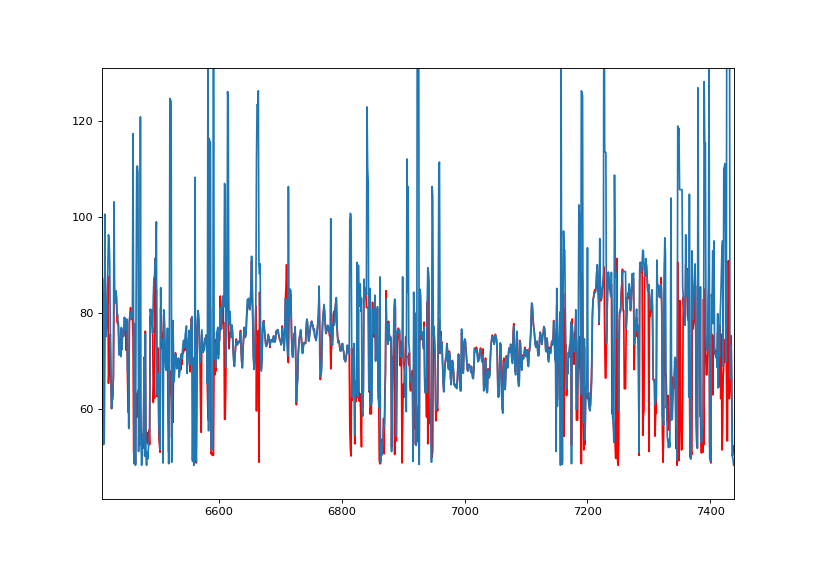

In [112]:
%matplotlib notebook
plt.figure(figsize=(10,7))
# plt.plot(test_hr,'g')
plt.plot(y_pred,'r')
plt.plot(y_pred1)
plt.show()

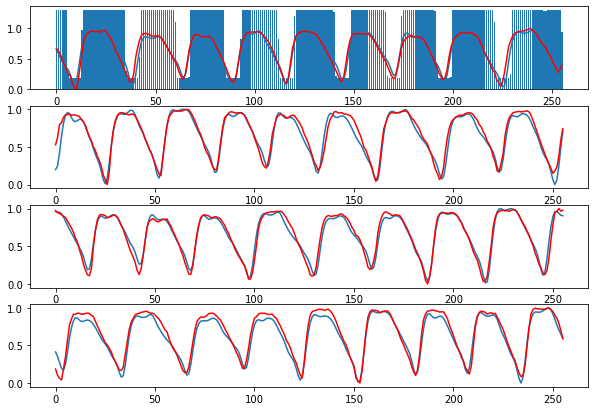

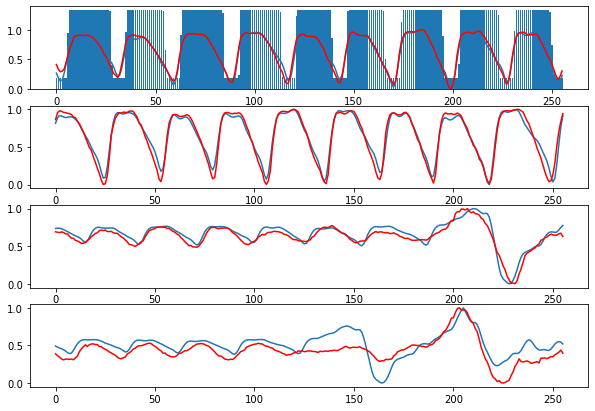

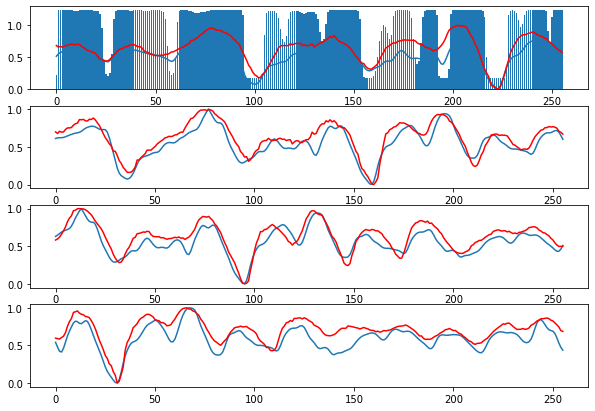

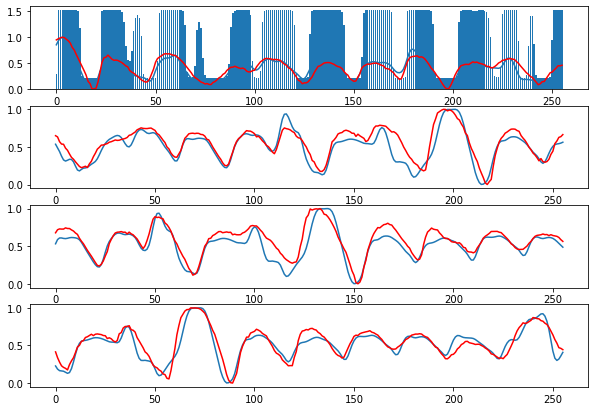

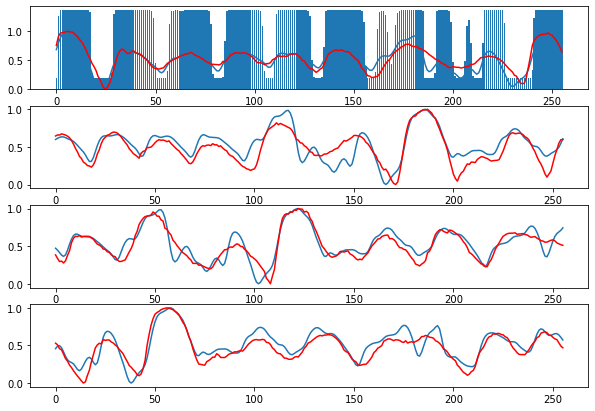

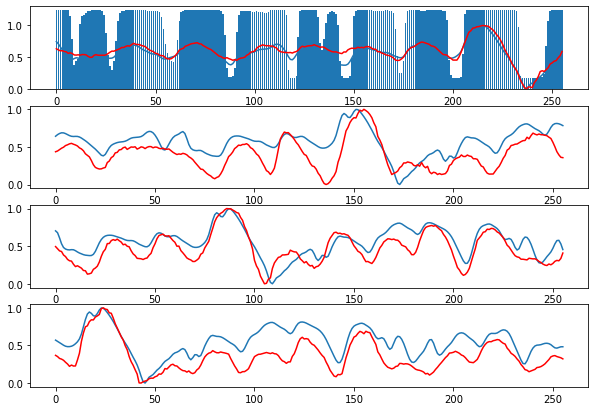

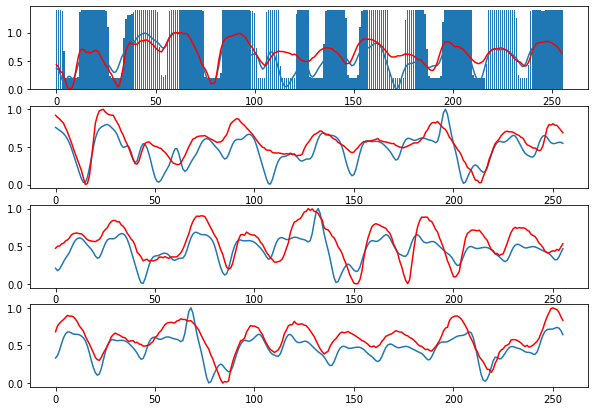

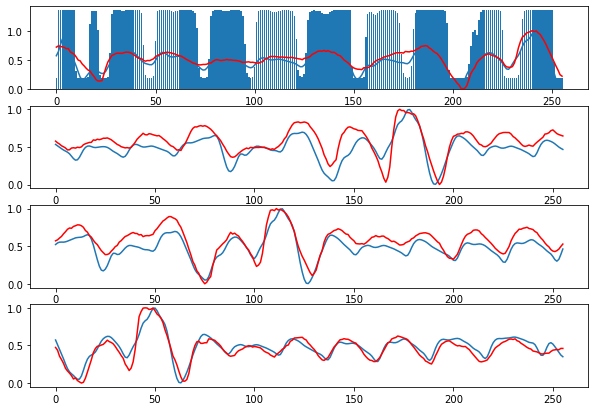

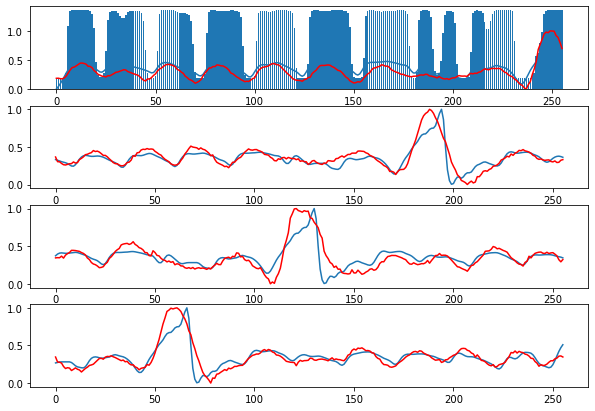

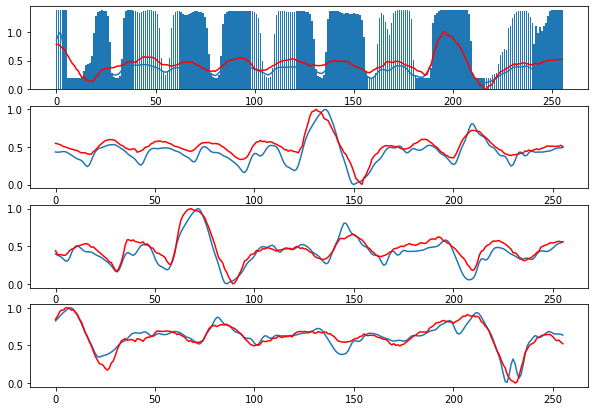

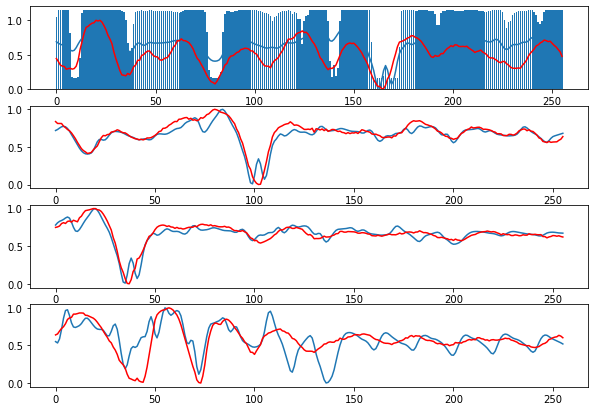

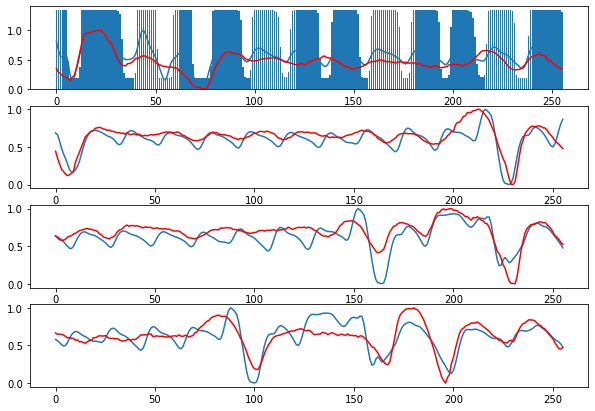

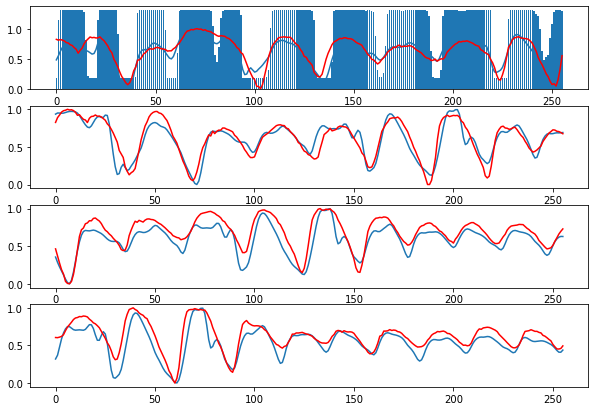

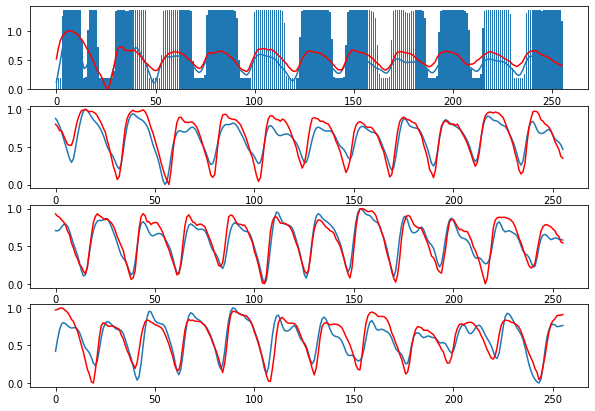

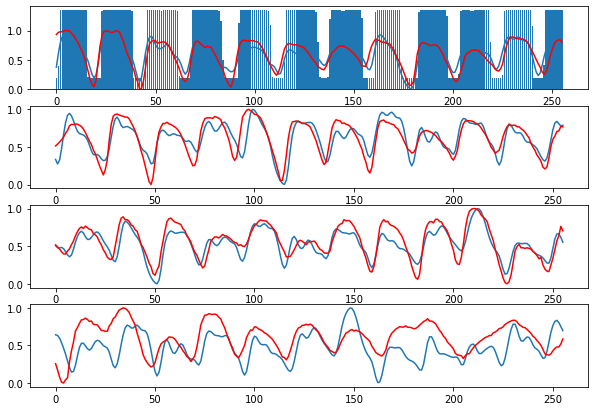

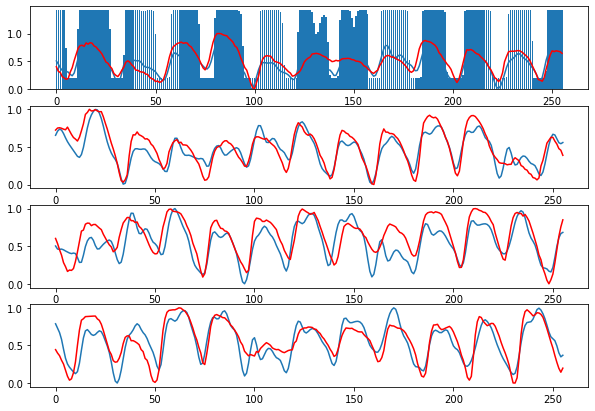

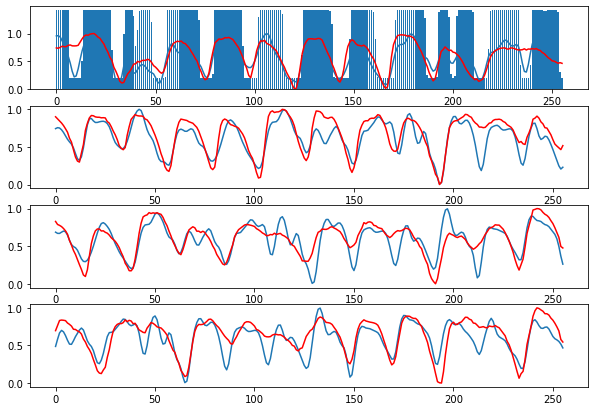

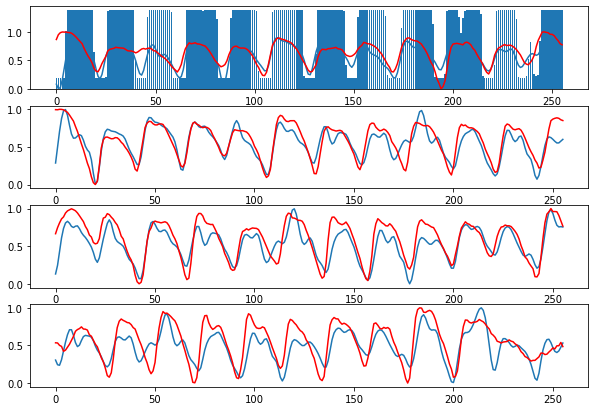

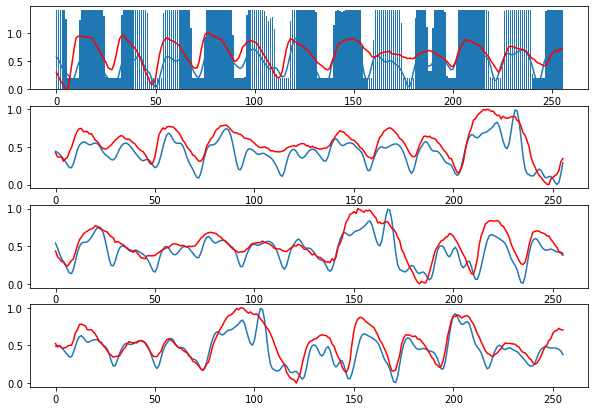

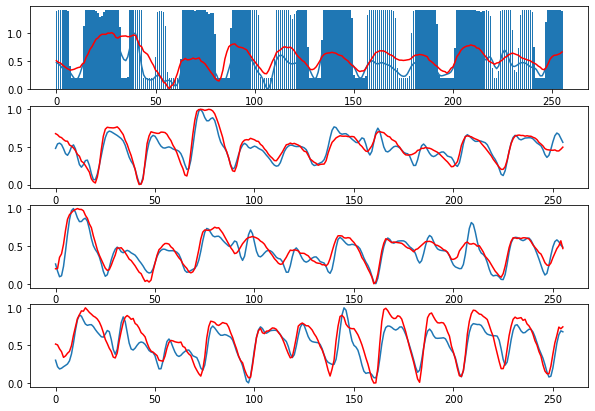

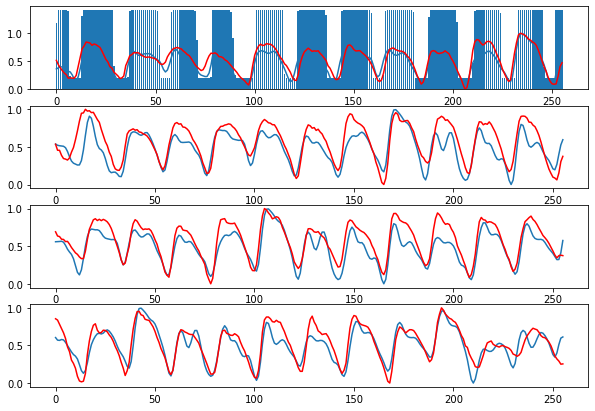

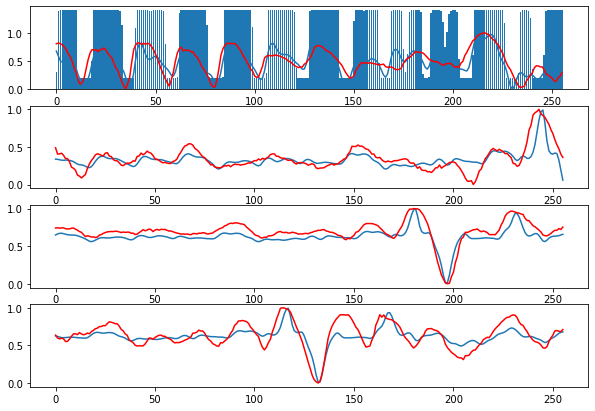

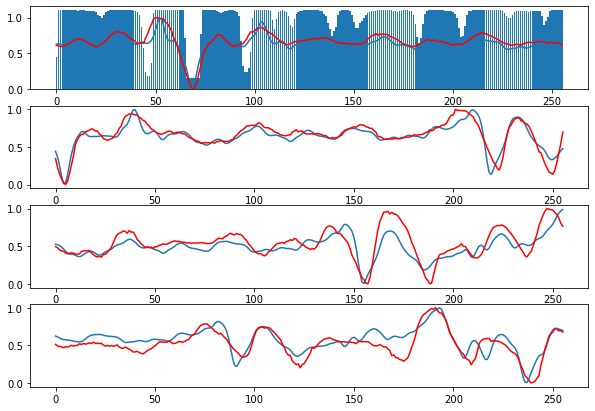

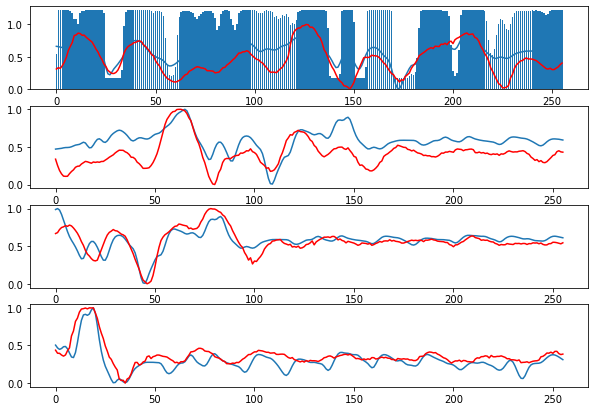

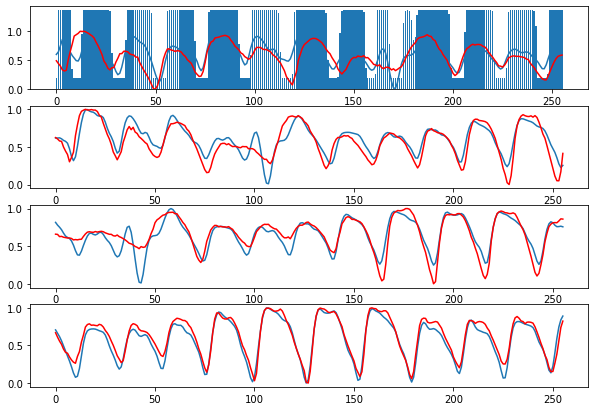

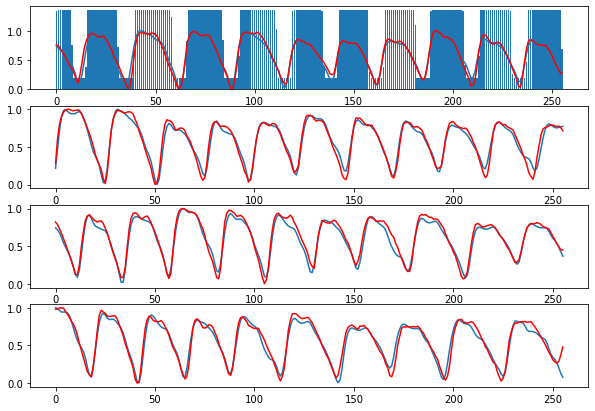

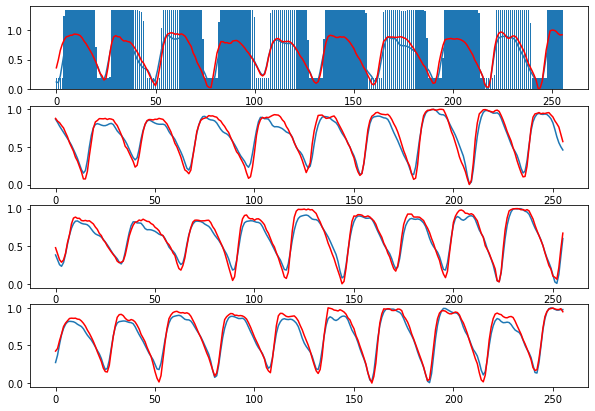

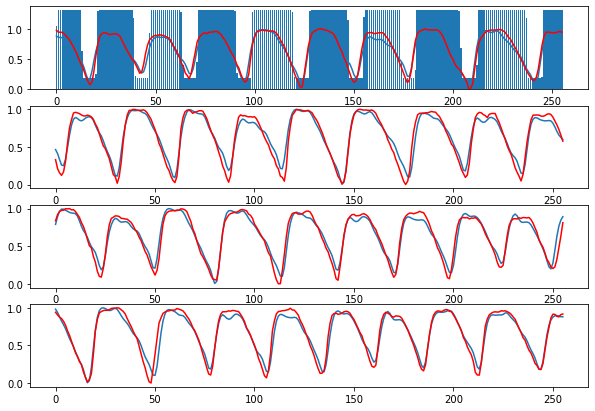

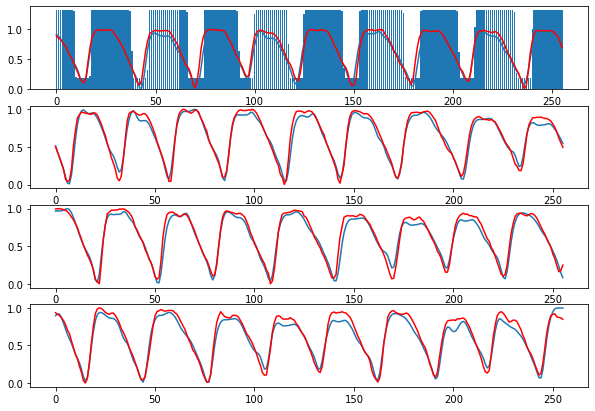

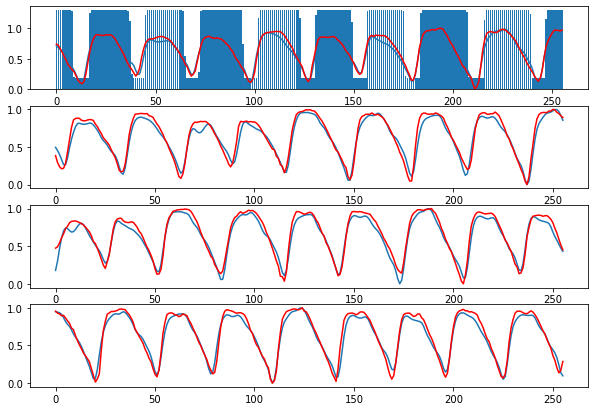

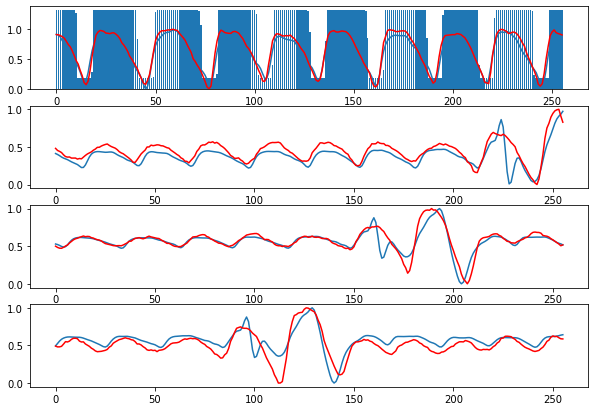

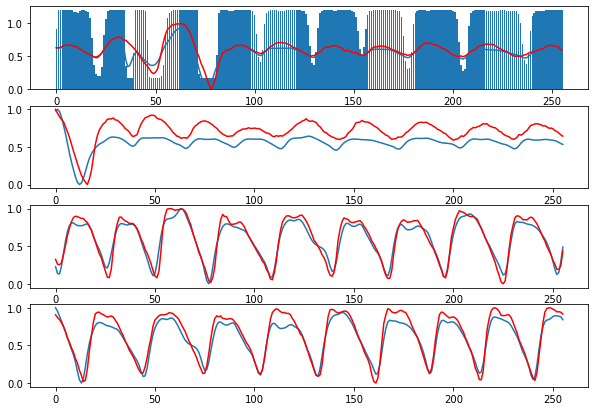

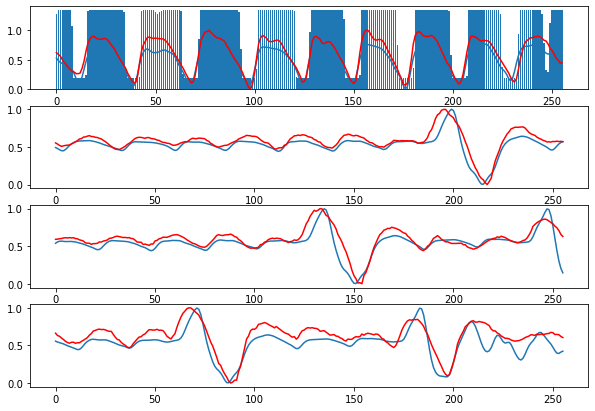

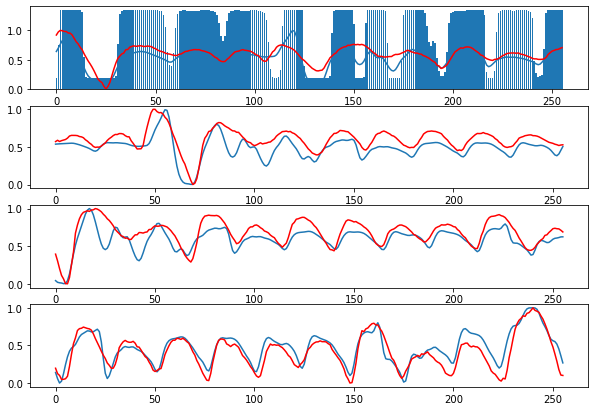

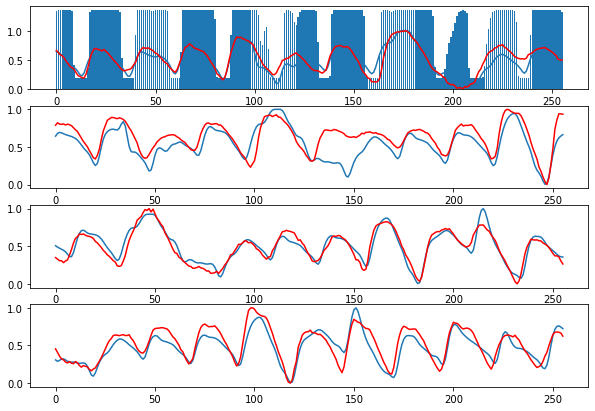

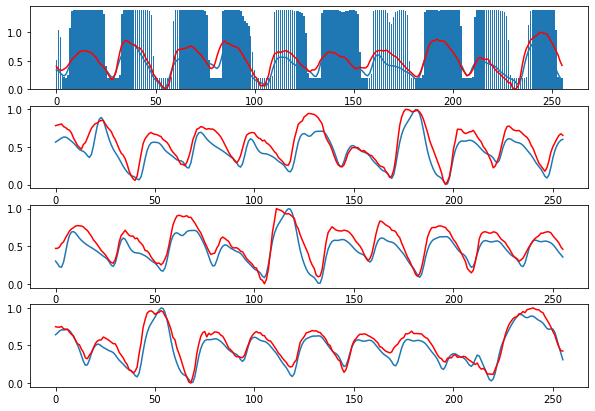

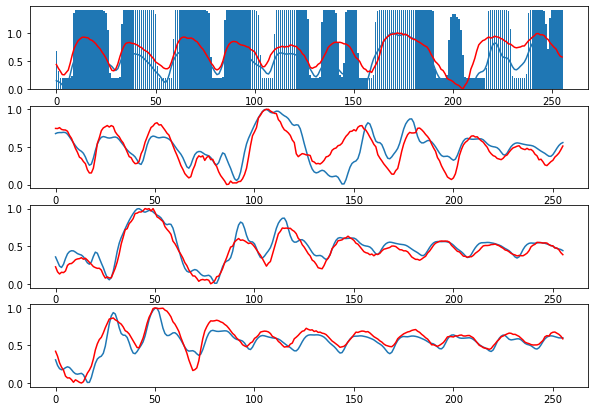

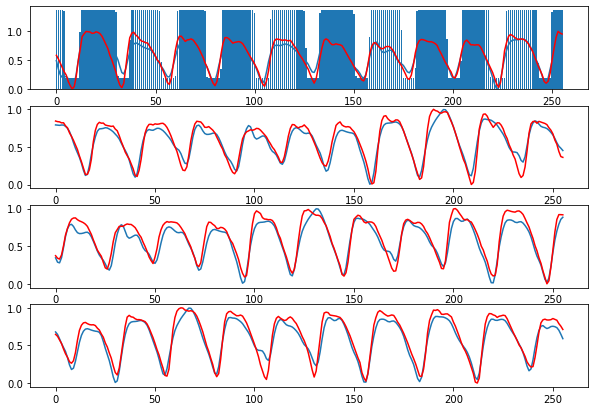

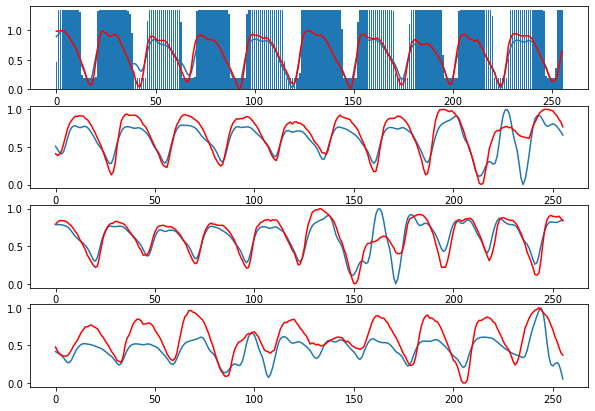

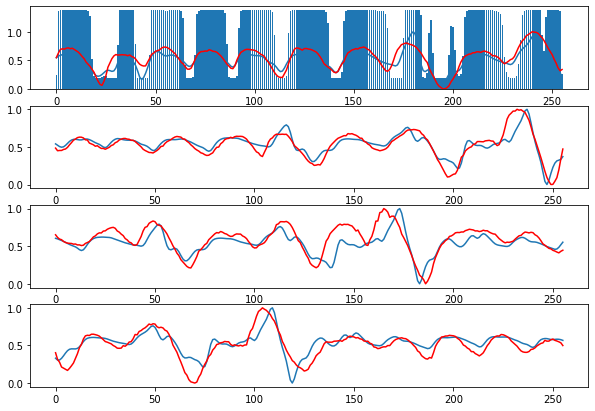

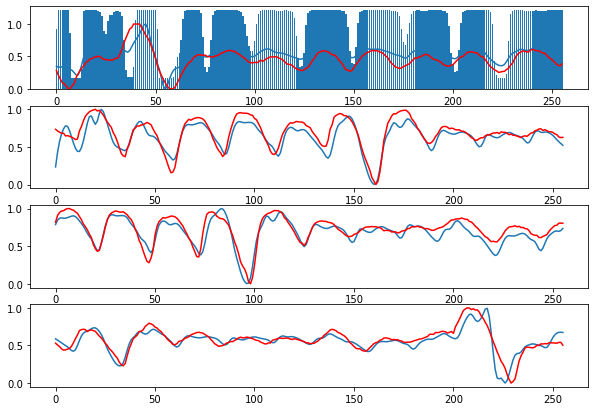

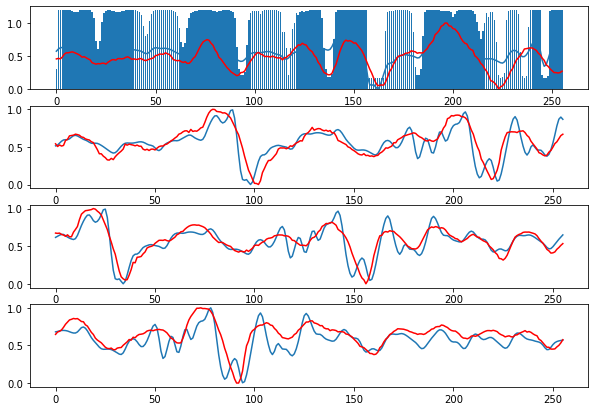

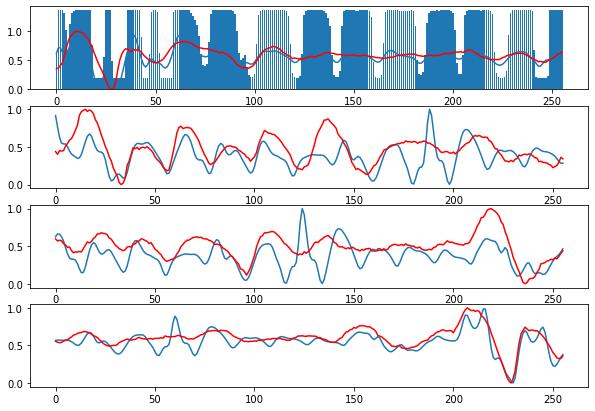

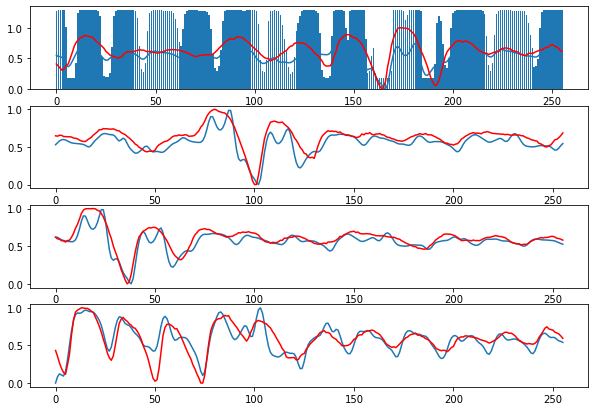

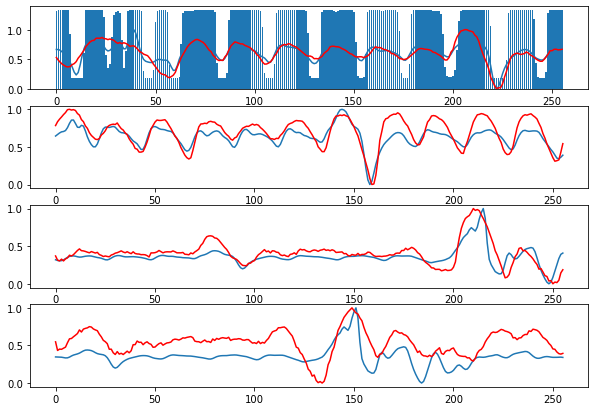

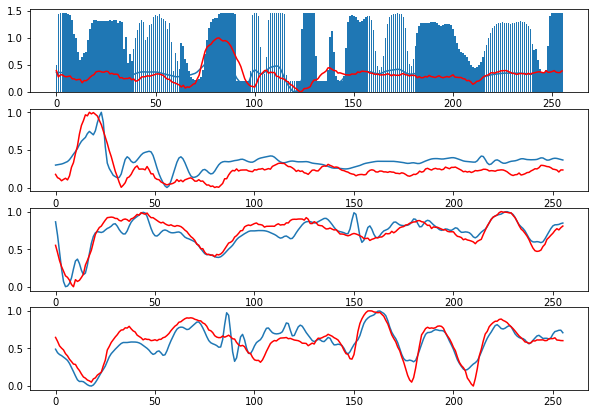

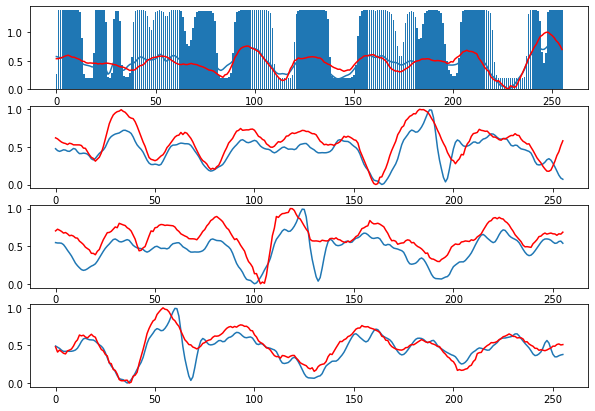

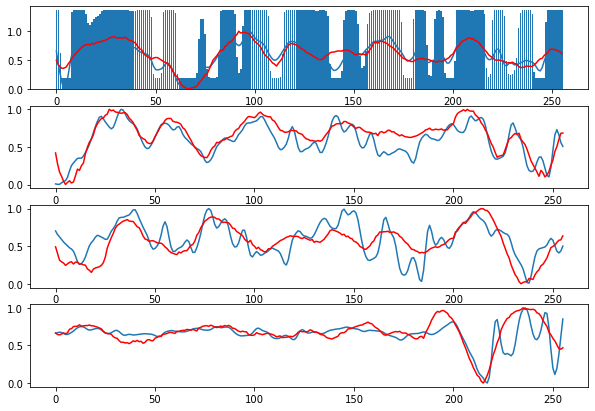

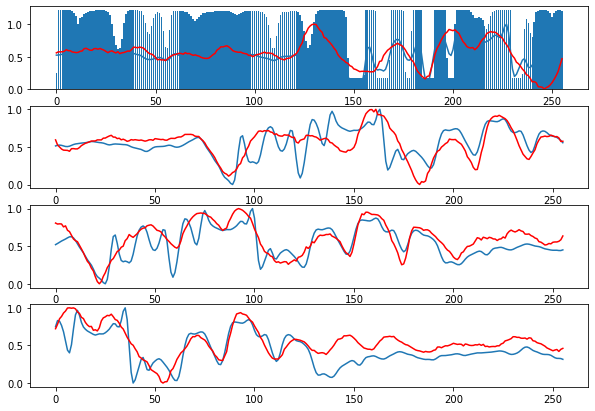

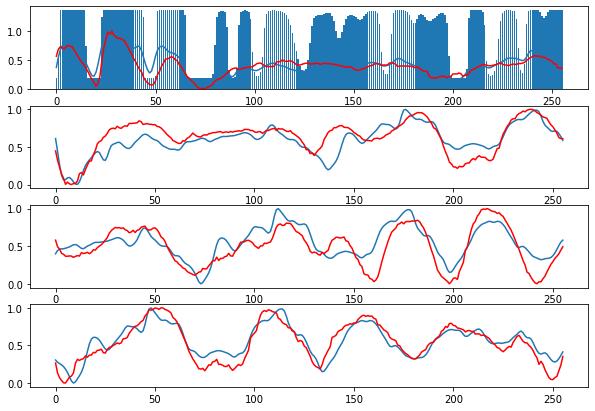

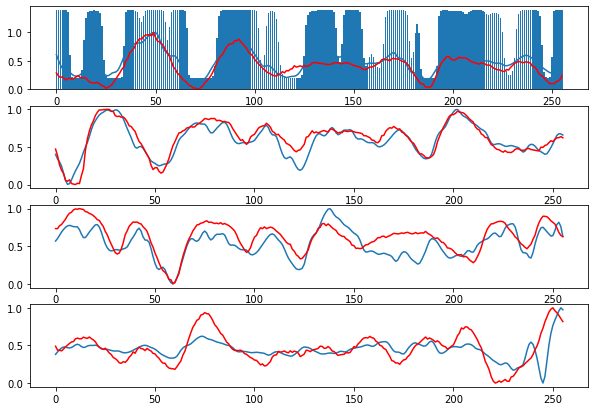

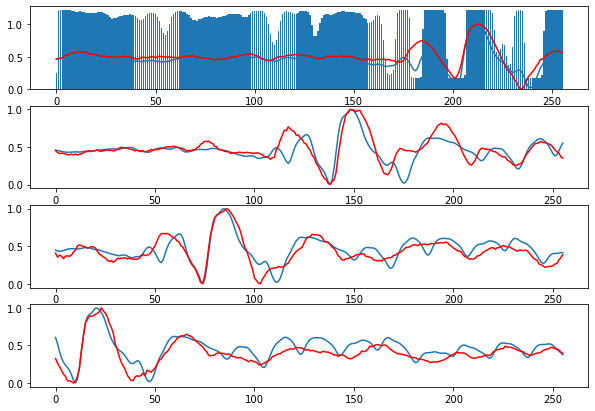

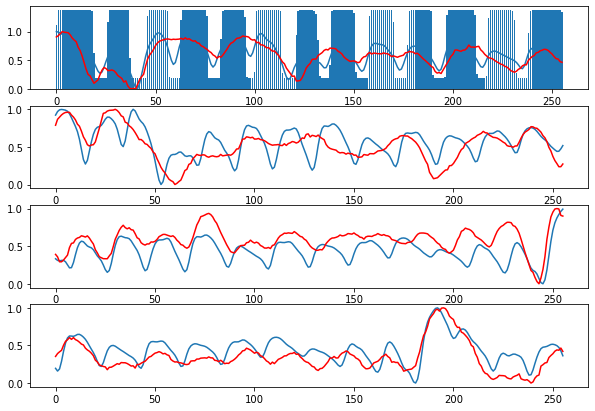

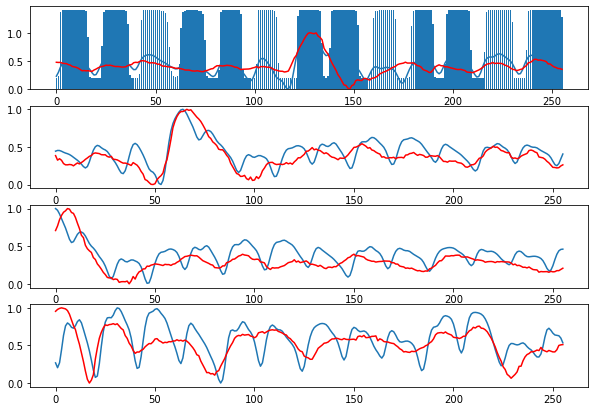

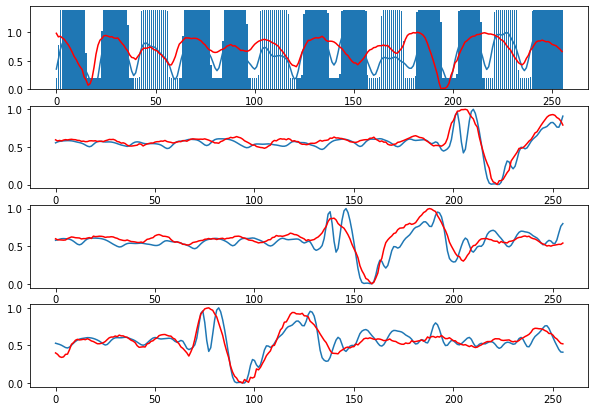

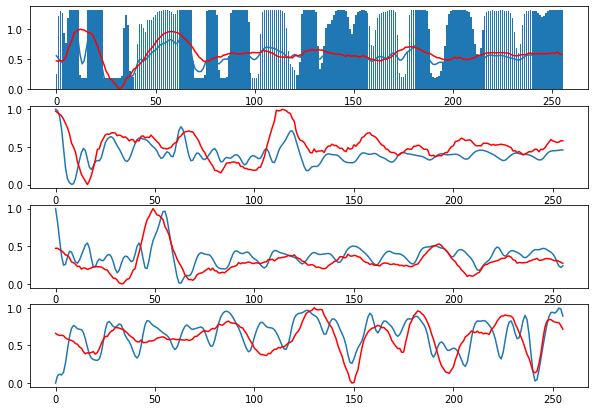

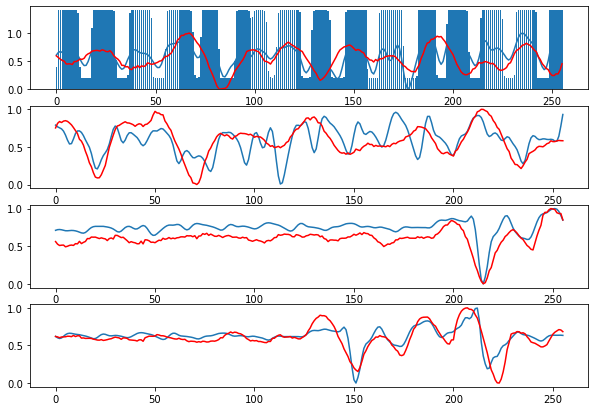

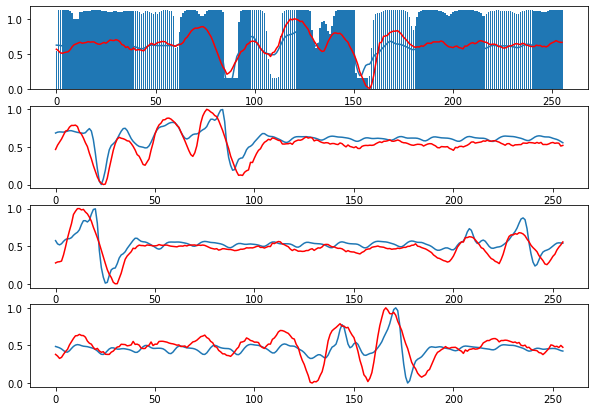

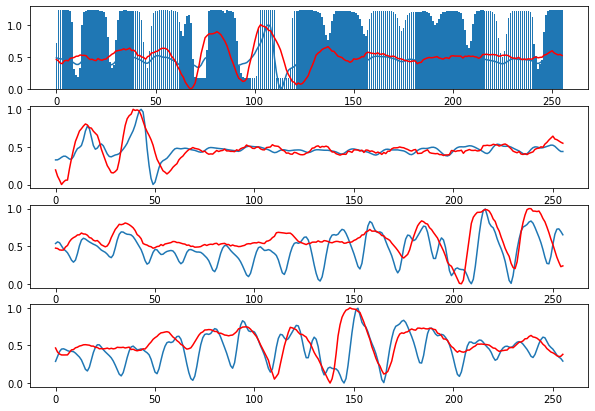

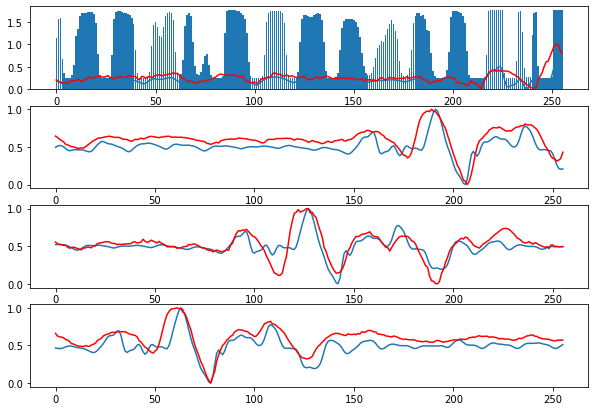

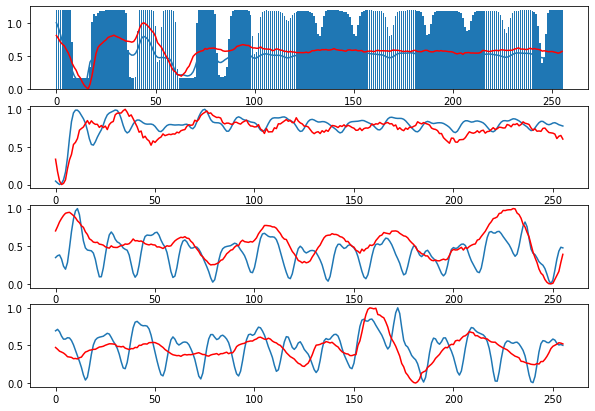

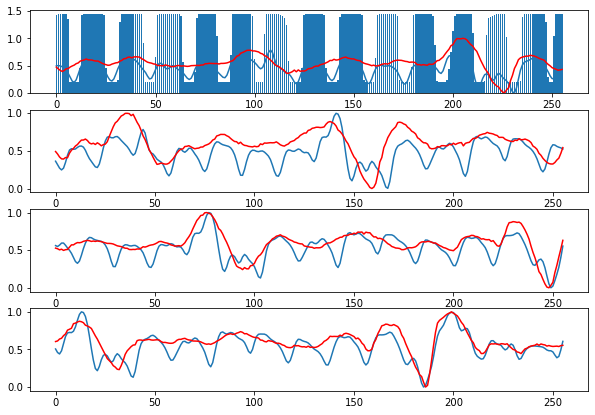

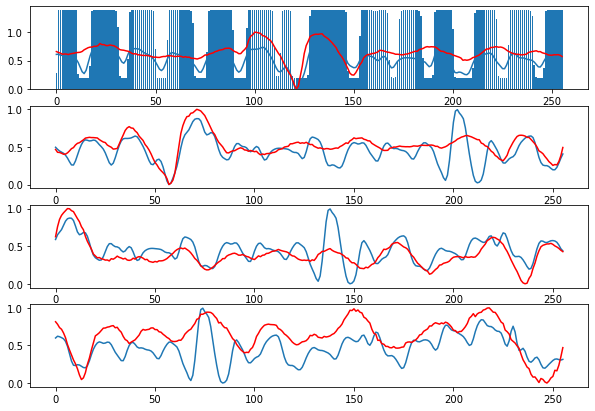

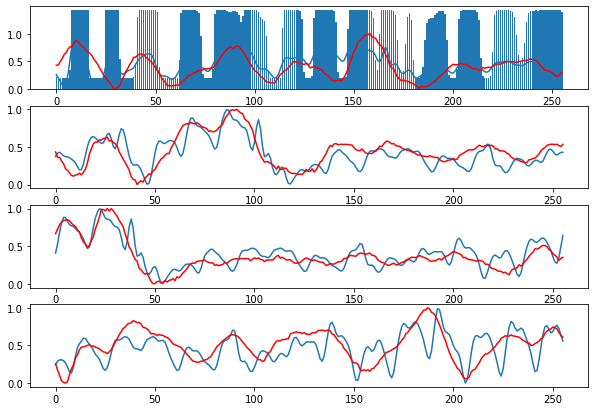

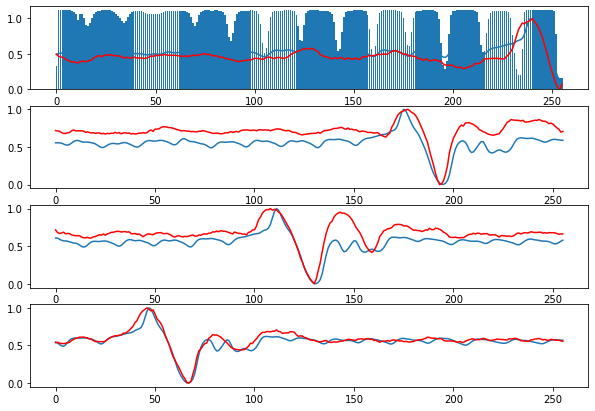

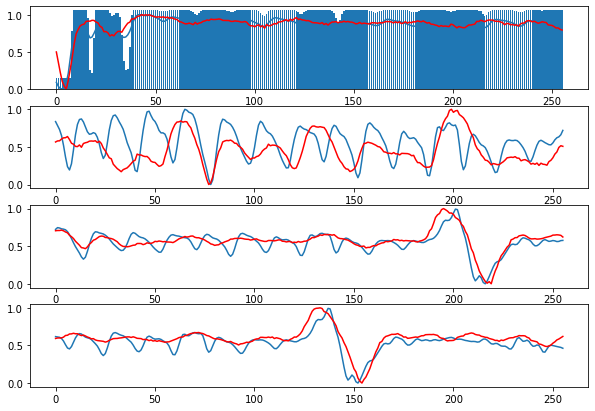

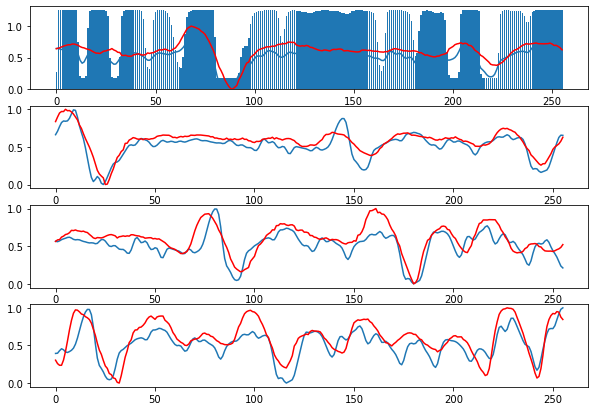

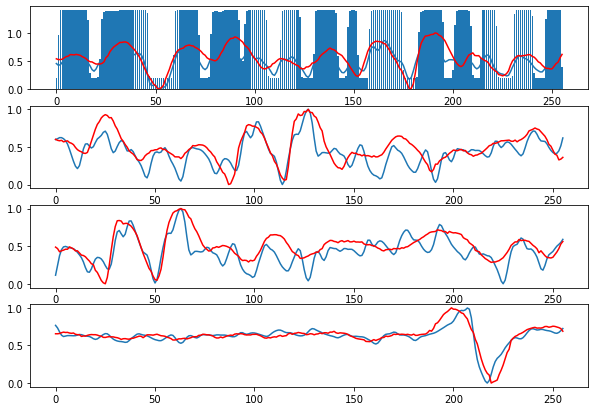

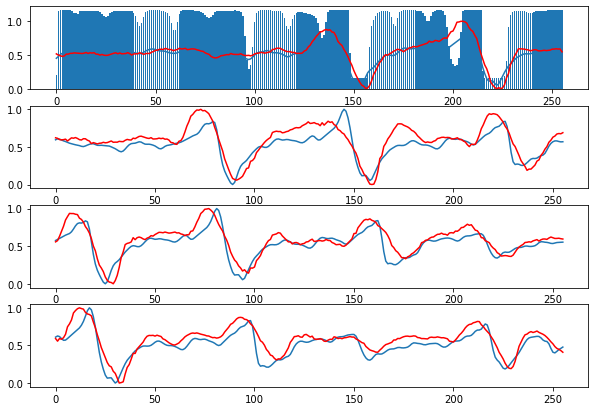

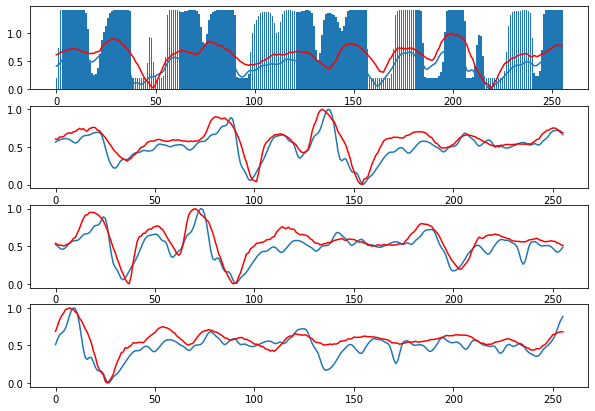

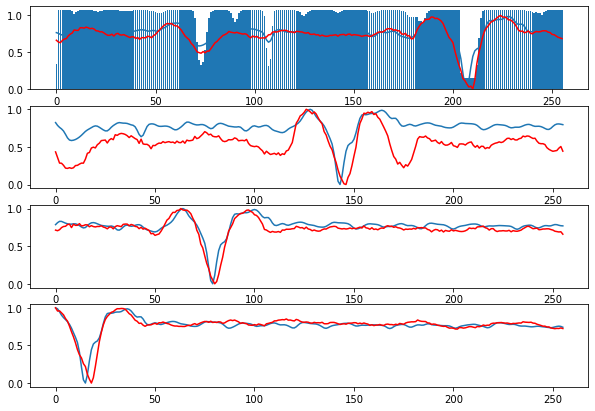

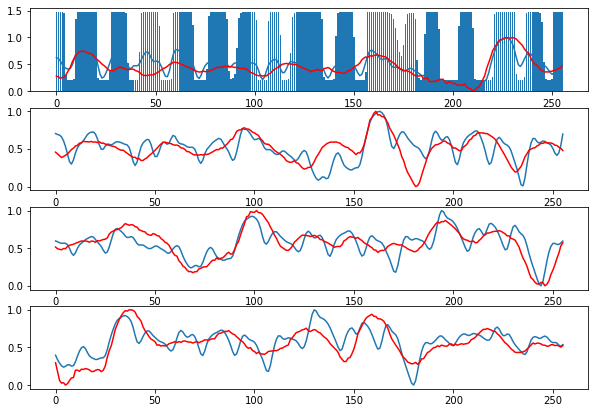

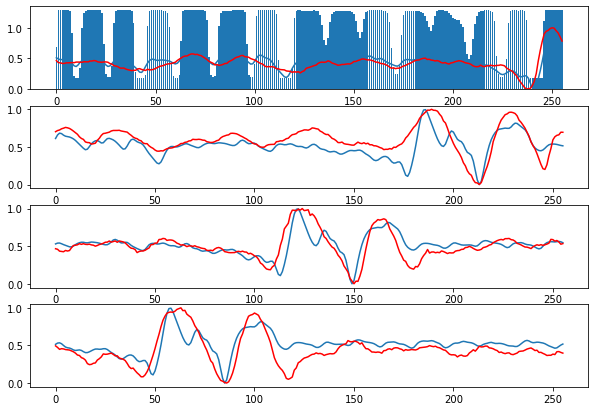

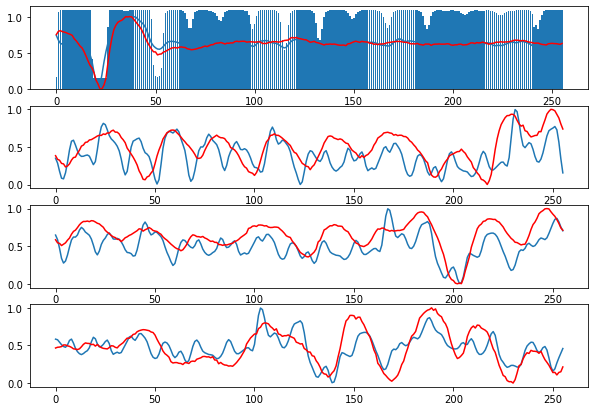

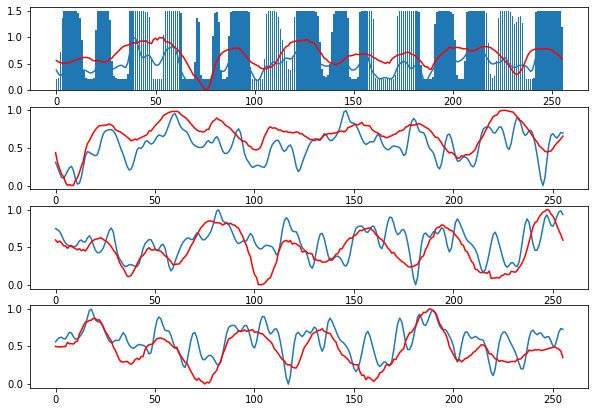

In [62]:
%matplotlib inline
for i in range(600,900,4):
    
    fig,ax = plt.subplots(4,1,figsize=(10,7))
    ax[0].plot(test_y[i])
    ax[0].plot(test_y_pred[i],'r')
    ax[0].bar(np.array(list(range(256))),test_y_pred_att[i].reshape(-1),.8)
    
    ax[1].plot(test_y[i+1])
    ax[1].plot(test_y_pred[i+1],'r')
    ax[2].plot(test_y[i+2])
    ax[2].plot(test_y_pred[i+2],'r')
    ax[3].plot(test_y[i+3])
    ax[3].plot(test_y_pred[i+3],'r')
    
    plt.show()

In [24]:
y_pred_attention = 1+y_pred[:,:,1]
    y_pred = y_pred[:,:,0]
    y_true = y_true[:,:,0]
    loss = K.sum(K.square(y_true-y_pred)*y_pred_attention)

IndentationError: unexpected indent (<ipython-input-24-bf11438045ff>, line 2)

In [68]:
test_y_pred_att

array([[[0.0194663 ],
        [0.01402935],
        [0.01057811],
        ...,
        [0.0092735 ],
        [0.01230255],
        [0.02068709]],

       [[0.02245263],
        [0.016595  ],
        [0.01274893],
        ...,
        [0.00939631],
        [0.0124062 ],
        [0.02066338]],

       [[0.02552951],
        [0.01927997],
        [0.01420288],
        ...,
        [0.00914429],
        [0.01222077],
        [0.02072514]],

       ...,

       [[0.02368994],
        [0.01718747],
        [0.01301126],
        ...,
        [0.00975859],
        [0.01283286],
        [0.02182434]],

       [[0.0229666 ],
        [0.01663608],
        [0.01261273],
        ...,
        [0.00916685],
        [0.01211728],
        [0.020863  ]],

       [[0.02321721],
        [0.01683053],
        [0.01273369],
        ...,
        [0.00955291],
        [0.01270316],
        [0.02180321]]], dtype=float32)

In [53]:
y_pred = K.variable(np.random.uniform(0,2,(500,256,2)))

In [48]:
y_pred_attention = 1+y_pred[:,:,1]
y_pred = y_pred[:,:,0]

In [49]:
y_true = K.variable(np.random.uniform(0,2,(500,256,1)))

In [50]:
y_true = y_true[:,:,0]

In [51]:
K.mean(K.sqrt(K.square(y_true-y_pred)*y_pred_attention))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9367105>

In [54]:
K.mean(y_pred[:,:,1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.99995047>